In [14]:
import pandas as pd
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder,OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from pandasql import sqldf
from xgboost import XGBClassifier

In [15]:
def wrangle(filename):  
  # Reading from csv file
  df = pd.read_csv(filename,index_col = "building_id")

  # Dropping rows with NA values
  df.dropna(inplace=True)

  # Dropping columns containing post eq information
  df.drop(columns=["count_floors_post_eq","height_ft_post_eq","condition_post_eq","technical_solution_proposed"],inplace=True)

  # Dropping columns with not_req id
  df.drop(columns=["district_id","vdcmun_id"],inplace=True)

  #Dropping height_ft_pre_eq as it is correlated to count_floors_pre_eq
  df.drop(columns="height_ft_pre_eq",inplace=True)

  return df

In [16]:
df = wrangle("csv_building_structure.csv")
df.head()

,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,120703,1,9,288,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,1,0,0,0,Grade 3
120101000021,120703,1,15,364,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,1,0,0,0,Grade 5
120101000031,120703,1,20,384,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,0,0,0,0,Grade 2
120101000041,120703,1,20,312,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,0,0,0,0,Grade 2
120101000051,120703,1,30,308,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,0,0,0,0,0,0,0,0,0,Grade 1


In [17]:
# Refer to earthquake_data_vis for these removals
df.drop(columns="has_superstructure_cement_mortar_brick",inplace=True)
df.drop(columns="has_superstructure_bamboo",inplace=True)

## Joining tables

In [18]:
df_mapping = pd.read_csv("ward_level_pred_intensity.csv")
df_mapping.drop(columns=["latitude","longitude"],inplace=True)
df_mapping.head()

,ward_id,pred_intensity
0,120101,6.928824
1,120102,6.986425
2,120103,6.960487
3,120104,6.881559
4,120105,6.878566


In [19]:
pysqldf = lambda q: sqldf(q, globals())

In [20]:
df = pysqldf("""
    select *
    from df
    inner join df_mapping
    on df.ward_id = df_mapping.ward_id
""")

In [21]:
df.head()

,building_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,...,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_timber,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade,ward_id,pred_intensity
0,120101000011,120703,1,9,288,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,...,0,0,0,0,0,0,0,Grade 3,120703,6.508394
1,120101000021,120703,1,15,364,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,...,0,0,0,0,0,0,0,Grade 5,120703,6.508394
2,120101000031,120703,1,20,384,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,...,0,0,0,0,0,0,0,Grade 2,120703,6.508394
3,120101000041,120703,1,20,312,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,...,0,0,0,0,0,0,0,Grade 2,120703,6.508394
4,120101000051,120703,1,30,308,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,...,0,0,0,0,0,0,0,Grade 1,120703,6.508394


In [22]:
df.drop(columns="ward_id",inplace=True)

In [23]:
df.head()

,building_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_timber,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade,pred_intensity
0,120101000011,1,9,288,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,1,0,0,0,0,0,0,0,Grade 3,6.508394
1,120101000021,1,15,364,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,1,0,0,0,0,0,0,0,Grade 5,6.508394
2,120101000031,1,20,384,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,1,0,0,0,0,0,0,0,Grade 2,6.508394
3,120101000041,1,20,312,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,1,0,0,0,0,0,0,0,Grade 2,6.508394
4,120101000051,1,30,308,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,...,1,0,0,0,0,0,0,0,Grade 1,6.508394


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759998 entries, 0 to 759997
Data columns (total 22 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             759998 non-null  int64  
 1   count_floors_pre_eq                     759998 non-null  int64  
 2   age_building                            759998 non-null  int64  
 3   plinth_area_sq_ft                       759998 non-null  int64  
 4   land_surface_condition                  759998 non-null  object 
 5   foundation_type                         759998 non-null  object 
 6   roof_type                               759998 non-null  object 
 7   ground_floor_type                       759998 non-null  object 
 8   other_floor_type                        759998 non-null  object 
 9   position                                759998 non-null  object 
 10  plan_configuration                      7599

In [25]:
df.set_index('building_id',inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 759998 entries, 120101000011 to 366709001281
Data columns (total 21 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   count_floors_pre_eq                     759998 non-null  int64  
 1   age_building                            759998 non-null  int64  
 2   plinth_area_sq_ft                       759998 non-null  int64  
 3   land_surface_condition                  759998 non-null  object 
 4   foundation_type                         759998 non-null  object 
 5   roof_type                               759998 non-null  object 
 6   ground_floor_type                       759998 non-null  object 
 7   other_floor_type                        759998 non-null  object 
 8   position                                759998 non-null  object 
 9   plan_configuration                      759998 non-null  object 
 10  has_superstructure_adobe_mud    

In [27]:
damage = {
    "Grade 1" : 0,
    "Grade 2" : 1,
    "Grade 3" : 2,
    "Grade 4" : 3,
    "Grade 5" : 4
}
df["damage_grade"]=df["damage_grade"].replace(damage)

C:\Users\Dell\AppData\Local\Temp\ipykernel_15008\43839025.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["damage_grade"]=df["damage_grade"].replace(damage)


# SPLIT

In [28]:
# X, y Split
target = "damage_grade"
X = df.drop(columns=target)
y = df[target]
print(f"X = {X.shape}, y = {y.shape}")

X = (759998, 20), y = (759998,)


In [29]:
# Train,Test Split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(607998, 20) (607998,)
(152000, 20) (152000,)


In [30]:
model = make_pipeline(OrdinalEncoder(),XGBClassifier(verbosity= 3,random_state =42,max_depth=8,min_child_weight = 1))

In [31]:
param_grid = {
    'xgbclassifier__learning_rate': [0.01, 0.1],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__min_child_weight': [1, 3],
    'xgbclassifier__subsample': [0.7, 0.9],
    'xgbclassifier__colsample_bytree': [0.7, 0.9],
    'xgbclassifier__n_estimators': [100, 200]
}

In [32]:
grid_search = GridSearchCV(model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=3, n_jobs=-1)

In [83]:
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

Best parameters:  {'xgbclassifier__colsample_bytree': 0.9, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__subsample': 0.7}


In [34]:
best_model = make_pipeline(OrdinalEncoder(),XGBClassifier(verbosity= 3,random_state =42, colsample_bytree = 0.9,learning_rate=0.1, max_depth=7, min_child_weight = 1,n_estimators=200,subsample = 0.7))

In [35]:
best_model.fit(X_train,y_train)

[14:34:42] ======== Monitor (0): HostSketchContainer ========
[14:34:42] AllReduce: 0.002546s, 1 calls @ 2546us

[14:34:42] MakeCuts: 0.002604s, 1 calls @ 2604us

[14:34:42] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[14:35:35] ======== Monitor (0): Learner ========
[14:35:35] Configure: 0.000556s, 1 calls @ 556us

[14:35:35] EvalOneIter: 0.002655s, 200 calls @ 2655us

[14:35:35] GetGradient: 8.75376s, 200 calls @ 8753756us

[14:35:35] PredictRaw: 0.003385s, 200 calls @ 3385us

[14:35:35] UpdateOneIter: 53.5451s, 200 calls @ 53545099us

[14:35:35] ======== Monitor (0): GBTree ========
[14:35:35] BoostNewTrees: 44.785s, 200 calls @ 44784971us

[14:35:35] CommitModel: 0.000347s, 200 calls @ 347us

[14:35:35] ======== Monitor (0): HistUpdater ========
[14:35:35] BuildHistogram: 7.40514s, 6000 calls @ 7405139us

[14:35:35] EvaluateSplits: 0.512148s, 7000 calls @ 512148

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Moderate slope    1
Flat              2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'data_type': dtype('O'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [36]:
train_acc = best_model.score(X_train,y_train)
test_acc = best_model.score(X_test,y_test)
print(f"Training Accuracy = {train_acc}")
print(f"Testing Accuracy = {test_acc}")

[14:37:49] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
Training Accuracy = 0.5442534350441942
Testing Accuracy = 0.5280328947368421


In [38]:
importances = best_model.named_steps["xgbclassifier"].feature_importances_
feature_names = X_train.columns

df_importances = pd.DataFrame({
    'Features':feature_names,
    'Importances' : importances
}).sort_values(by='Importances', ascending=False)
df_importances.head(10)

,Features,Importances
11,has_superstructure_mud_mortar_stone,0.443819
19,pred_intensity,0.081909
4,foundation_type,0.070600
12,has_superstructure_stone_flag,0.051725
5,roof_type,0.047741
10,has_superstructure_adobe_mud,0.039075
14,has_superstructure_mud_mortar_brick,0.034349
7,other_floor_type,0.033789
6,ground_floor_type,0.027505
0,count_floors_pre_eq,0.024589


<Axes: xlabel='Importances', ylabel='Features'>

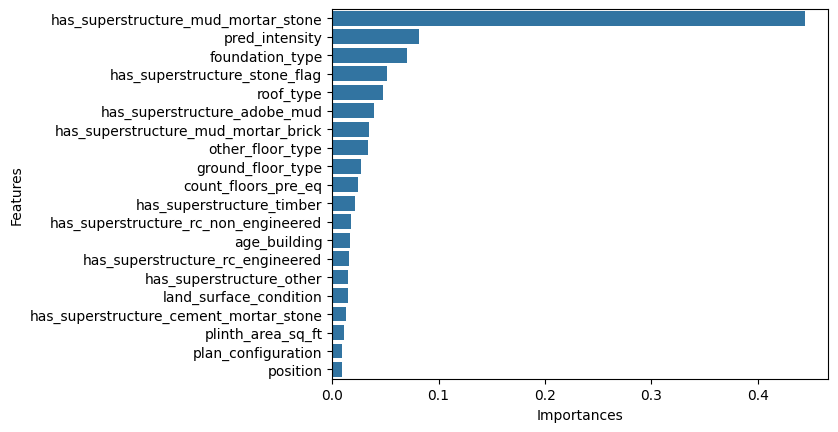

In [39]:
sns.barplot(x="Importances",y="Features",data=df_importances)

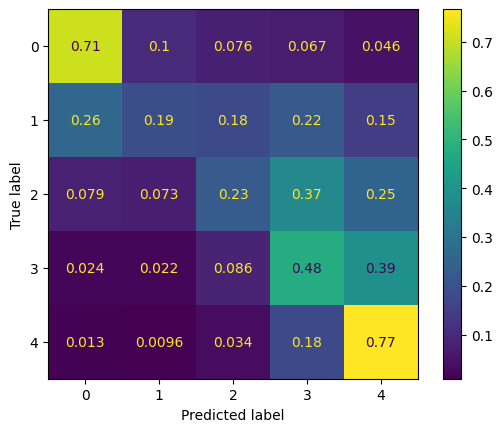

In [41]:
ConfusionMatrixDisplay.from_estimator(best_model,X_test,y_test,normalize='true')

In [43]:
print(classification_report(y_test,best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.71      0.64     15863
           1       0.40      0.19      0.26     17405
           2       0.40      0.23      0.29     27415
           3       0.42      0.48      0.44     36601
           4       0.63      0.77      0.69     54716

    accuracy                           0.53    152000
   macro avg       0.49      0.47      0.46    152000
weighted avg       0.51      0.53      0.50    152000



# Random Forest

In [47]:
model = make_pipeline(OrdinalEncoder(),RandomForestClassifier(verbose= 3,random_state =42,max_depth=16,n_estimators=200,n_jobs=-1))

In [48]:
model.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200building tree 10 of 200

building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s


building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   41.5s


building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Moderate slope    1
Flat              2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'data_type': dtype('O'...
Attached-2 side    3
Attached-3 side    4
NaN               -2
dtype: int64},
                                         {'col': 'plan_configuration',
                                          'data_type': dtype('O'),
                                          'mapping': Rectangular                         1
Square                              2
L-shape                             3
U-shape                             4
T-shape                             5
Multi-projected                     6
H-shape                             7
E-shape                             8
Others                              9
Building with Central Courtyard    10
NaN                                -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=16, n_estimators=200,
                                        n_jobs=-1, random_state=42,
                                        verbose=3))])

In [49]:
train_acc = model.score(X_train,y_train)
test_acc = model.score(X_test,y_test)
print(f"Training Accuracy = {train_acc}")
print(f"Testing Accuracy = {test_acc}")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.1s


Training Accuracy = 0.5639788288777265
Testing Accuracy = 0.5113552631578947


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished


In [51]:
importances =model.named_steps["randomforestclassifier"].feature_importances_
feature_names = X_train.columns

df_importances = pd.DataFrame({
    'Features':feature_names,
    'Importances' : importances
}).sort_values(by='Importances', ascending=False)
df_importances.head(10)

,Features,Importances
19,pred_intensity,0.405789
11,has_superstructure_mud_mortar_stone,0.109290
4,foundation_type,0.078707
1,age_building,0.069317
2,plinth_area_sq_ft,0.064719
5,roof_type,0.048028
6,ground_floor_type,0.037570
7,other_floor_type,0.037492
0,count_floors_pre_eq,0.033816
15,has_superstructure_timber,0.015992


<Axes: xlabel='Importances', ylabel='Features'>

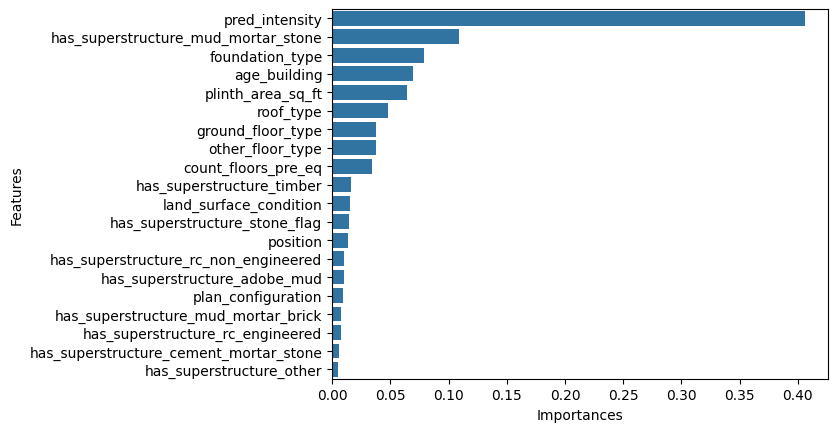

In [52]:
sns.barplot(x="Importances",y="Features",data=df_importances)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished


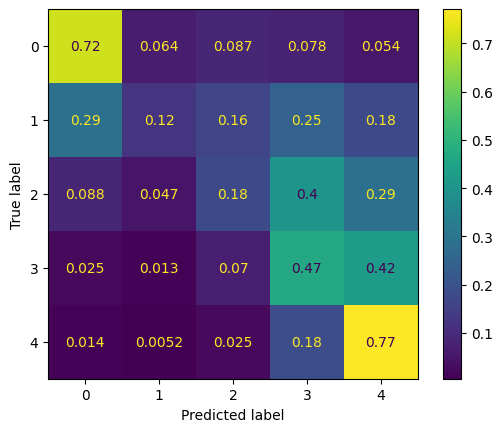

In [53]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,normalize='true')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished


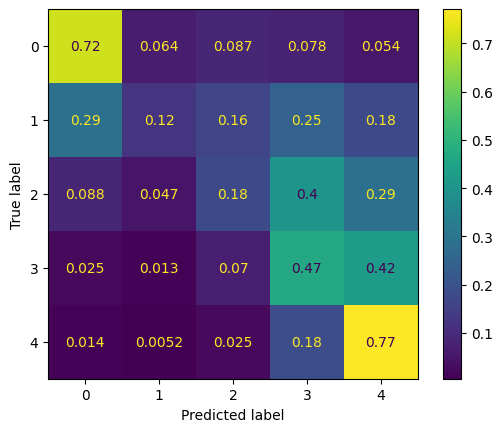

In [54]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,normalize='true')